

# CNN
Laden des auf IDS18 trainierten Modells
Test auf komplettem IDS17

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


2024-10-30 11:20:08.543556: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 11:20:08.555581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 11:20:08.576022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 11:20:08.579976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 11:20:08.589730: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
parquet_verzeichnis_ids17 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet'
parquet_verzeichnis_ids18 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet'

### Laden von IDS17

In [3]:
# IDS17 Datensatz einlesen
df = pd.read_parquet(os.path.join(parquet_verzeichnis_ids17 + '_prep_0'))
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

2024-10-30 11:21:06 - INFO - Class distribution
Label
BENIGN                          1582561
DoS Hulk                         158468
DDoS-LOIC-HTTP                    95144
Infiltration - NMAP Portscan      71767
DoS GoldenEye                      7567
DoS Slowloris                      3859
SSH-BruteForce                     2961
Botnet Ares                         736
Web Attack - Brute Force             73
Web Attack - XSS                     18
Web Attack - SQL                     13
Name: count, dtype: int64


In [4]:
df.columns

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       

In [5]:
df.shape

(1923167, 84)

### Trennen von Features und Labels

In [6]:
# Letzte Spalte 'Label' ist die Zielvariable

X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (1923167, 83)
Form von y: (1923167,)


In [7]:
X.head(2)

,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd RST Flags,Bwd RST Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWR Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,ICMP Code,ICMP Type,Total TCP Flow Time
0,3268,6,112740690,32,16,6448.0,1152.0,403.0,0.0,201.5,204.724197,72.0,72.0,72.0,0.0,67.411331,0.425756,2398738.00,5798698.0,16399772.0,3.0,112740688.0,3636796.50,6848761.0,16399772.0,3.0,112740352.0,7516023.0,8323385.0,16400110.0,3.0,16,16,0,0,0,0,1024,512,0.283837,0.141919,0.0,403.0,158.333328,177.341751,31450.099291,0,0,0,32,48,0,0.0,0.0,0.5,158.333333,201.5,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.0,0.0,24.0,377.0,2079.0,15.0,32.0,359.428571,11.998016,380.0,343.0,1.610540e+07,498804.820328,16399772.0,15375229.0,-1.0,-1.0,112740690.0
1,389,6,112740560,32,16,6448.0,5056.0,403.0,0.0,201.5,204.724197,316.0,316.0,316.0,0.0,102.039589,0.425756,2398735.25,5798709.5,16399782.0,2.0,112740560.0,3636792.25,6848777.0,16399782.0,2.0,112740240.0,7516016.0,8323376.0,16400110.0,4.0,16,16,0,0,0,0,1024,512,0.283838,0.141919,0.0,403.0,239.666672,174.984177,30619.460993,0,0,0,32,48,0,0.0,0.0,0.5,239.666667,201.5,316.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,134.0,0.0,105.0,955.0,2079.0,15.0,32.0,320.285714,15.744992,330.0,285.0,1.610543e+07,498793.665561,16399782.0,15375263.0,-1.0,-1.0,112740560.0


In [8]:
y.head(2)

0    BENIGN
1    BENIGN
Name: Label, dtype: object

### Label Encoding für y

In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [10]:
print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce'
 'Web Attack - Brute Force' 'Web Attack - SQL' 'Web Attack - XSS']
Kodierte Labels: [ 0  1  2  3  4  5  6  7  8  9 10]


### Skallierung von X

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

Form von X: (1923167, 83)
Form von X_scaled: (1923167, 83)


### Umformen der Daten für das CNN

In [13]:
# Anzahl der Features
num_features = X_scaled.shape[1]  # Sollte 83 sein

# Umformen zu (Anzahl_Beispiele, num_features, 1)
X_reshaped = X_scaled.reshape(-1, num_features, 1)
print("Form von X_reshaped:", X_reshaped.shape)  # Erwartet: (1923167, 83, 1)

Form von X_reshaped: (1923167, 83, 1)


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [14]:
X_test, y_test = X_reshaped, y_encoded

In [15]:
X_test.shape, y_test.shape

((1923167, 83, 1), (1923167,))

### Überprüfen der Klassenverteilung

In [16]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 1582561 Beispiele (82.29%)
  Klasse 1: 736 Beispiele (0.04%)
  Klasse 2: 95144 Beispiele (4.95%)
  Klasse 3: 7567 Beispiele (0.39%)
  Klasse 4: 158468 Beispiele (8.24%)
  Klasse 5: 3859 Beispiele (0.20%)
  Klasse 6: 71767 Beispiele (3.73%)
  Klasse 7: 2961 Beispiele (0.15%)
  Klasse 8: 73 Beispiele (0.00%)
  Klasse 9: 13 Beispiele (0.00%)
  Klasse 10: 18 Beispiele (0.00%)



### Laden des Modells

In [17]:
# from tensorflow import keras
# import joblib

# Laden des Modells
cnn_model = keras.models.load_model('ids18_cnn_model.h5')

# Laden des Label Encoders und Scalers
# label_encoder = joblib.load('label_encoder.pkl')
# scaler = joblib.load('scaler.pkl')

I0000 00:00:1730283786.716490  787933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730283786.740281  787933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730283786.740321  787933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730283786.743376  787933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730283786.743406  787933 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### Evaluierung des Modells auf dem Testdatensatz

In [18]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Testverlust: {test_loss:.4f}")
print(f"Testgenauigkeit: {test_accuracy:.4f}")

I0000 00:00:1730283794.989906  788629 service.cc:146] XLA service 0x7f5b0c005be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730283794.989936  788629 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-10-30 11:23:14.996774: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-30 11:23:15.019452: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  187/60099 ━━━━━━━━━━━━━━━━━━━━ 48s 810us/step - loss: 0.0069 - sparse_categorical_accuracy: 0.9976

I0000 00:00:1730283795.420191  788629 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60099/60099 ━━━━━━━━━━━━━━━━━━━━ 62s 1ms/step - loss: 2.2395 - sparse_categorical_accuracy: 0.8315
Testverlust: 2.7150
Testgenauigkeit: 0.8301


### Klassifikationsbericht und eine Konfusionsmatrix

In [19]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Konfusionsmatrix:")
print(cm)

60099/60099 ━━━━━━━━━━━━━━━━━━━━ 40s 667us/step


/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michi/BA/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                              precision    recall  f1-score   support

                      BENIGN       0.85      0.98      0.91   1582561
                 Botnet Ares       0.02      0.01      0.02       736
              DDoS-LOIC-HTTP       0.98      0.01      0.02     95144
               DoS GoldenEye       0.31      0.90      0.46      7567
                    DoS Hulk       0.19      0.03      0.05    158468
               DoS Slowloris       0.81      0.48      0.60      3859
Infiltration - NMAP Portscan       0.90      0.35      0.50     71767
              SSH-BruteForce       0.47      0.99      0.64      2961
    Web Attack - Brute Force       0.00      0.00      0.00        73
            Web Attack - SQL       0.00      0.00      0.00        13
            Web Attack - XSS       0.00      0.00      0.00        18

                    accuracy                           0.83   1923167
                   macro avg       0.41      0.34      0.29   1923167
                we

Visualisierung der Konfusionsmatrix

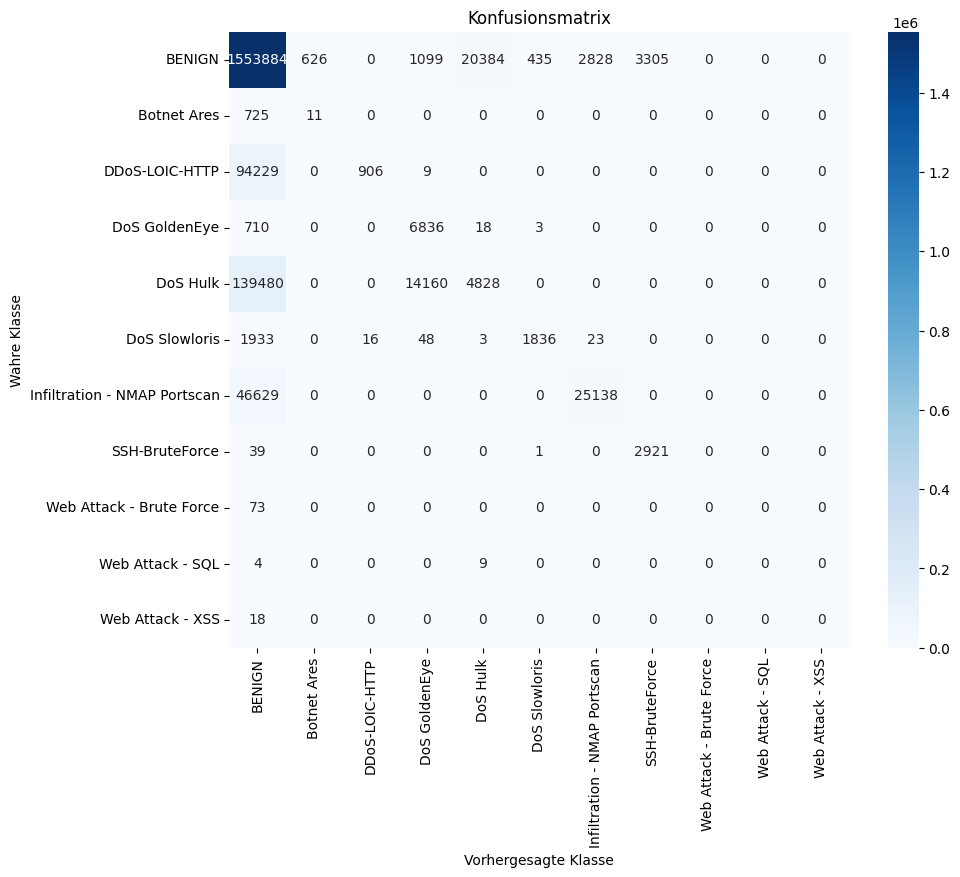

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()
